# Tier Analysis of PEPs to keep, enrich and delete


## Tier Schema


| Field                                                | Reject (if any is invalid)                                                                                | Insufficient (if any is missing)                  | Good enough                                    | Thresholds 1 | T2    | T3    |
|------------------------------------------------------|---------------------------------------------------------------------------------------------------------|--------------------------------|------------------------------------------------|---------------------------|-------|-------|
| **Name**                                                 | Invalid                                                                                                 | Missing                        | ✅                                          | ✅                     | ✅ | ✅ |
| **DoB**                                                  | `>200 years ago & <18                                                                                   | Missing                        | ✅                                          | ✅                     | ✅ | ✅ |
| **Occupation**                                           | Not a PEP ¿What about RCAs?                                                                             | Missing                        | ✅                                          | ✅                     | ✅ | ✅ |
| **Location**                                             | Reject if missing location/valid location. If value is a continent not useful, treat those as missing.  |                         | 🟡                                        | ✅  | ✅ | ✅ |
| **Source Url**                                           | Invalid url                                                                                             |                         | 🟡 | ✅                     | ✅ |       |
| **position start date***  | Reject if either start or end date missing |  | 🟡        | ✅                     |       |       |
| **DoD**                                                  | >100 years ago                                                                                          |                         | 🟡                                        |                           |       |       |



To understand the scale of enriching PEP profiles, we break PEPs into thresholds based on a set of conditions:

1. ✅ valid (1),
2. ❌ invalid (0),
3. missing (None).
4. 🟡 Present (either valid or invalid, not missing)
5. Blanks are fields that we are agnostic about. Value of data point can be missing, invalid, valid

A PEP can fall into one or more tiers. This gives us a funnel view of PEPs in our sources that describes how big the difference is between each tier.

In [1]:
import pandas as pd
import numpy as np
import os
%run queries.py
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Load Data
input_directory = '../../../sorcerer/src/parquet/'
input_files = [f for f in os.listdir(input_directory) if f.endswith('.parquet')]
list_df = []
for input_file in input_files:
    input_file_path = os.path.join(input_directory, input_file)
    data = pd.read_parquet(input_file_path)
    list_df.append(data)

data = pd.concat(list_df).reset_index(drop=True)
data = data.where(pd.notnull(data), None)

In [3]:
#Prepare data
data['_source.sources.source_ids'] = data['_source.sources.source_ids'].apply(lambda x: ', '.join(map(str, x)))
data['completeness'] = data['completeness'].replace(0, 'incomplete')

# Select Sources
LIST_SOURCE_SOURCE_IDS = ['S:FBFYW0 [DBPedia]','S:4CU7GM [PEP Everypolitician]', 'S:8L276A [Manual PEPs]', 'S:1GYJGG [The Official Board]', 'S:MFCNUA [PEP US Diplomat list 2]']
data = data[data['_source.sources.source_ids'].isin(LIST_SOURCE_SOURCE_IDS)]

#Remove RCAs
RCA_DBPEDIA = data[(data['_source.sources.source_ids'] == 'S:FBFYW0 [DBPedia]') & (data['PEP_id'] == False)]
data.drop(RCA_DBPEDIA.index, inplace=True)

## Processing Fields

### Name check

Names are non-negotiable. Either a PEP has a valid name or they do not. We therefore score invalid names 0 and valid names 1. 

In [4]:
name_check = data['TOTAL_FLAGS'].apply(lambda x: 0 if x > 0 else 1)

### Date of birth

For date of births, we return None for missing values, 0 for invalid ages that are <18 or >200 and 1 for valid ages

In [5]:
date_of_birth = data['_source.data.births.age'].apply(lambda x: None if pd.isna(x) else (0 if x <18 or x >= 200 else 1))

### Date of death

Date of death is valid if the date is <100 years ago otherwise invalid. There are missing values here. 

In [6]:
date_of_death = data['_source.data.deaths.years_since_death'].apply(lambda x: None if pd.isna(x) else (1 if x <=100 else 0))

### Occupation

We return None when there is no value is either display or occupation fields, 0 if there is but has_occupation is false, and 1 if the occupation is present and a valid PEP occupation.

In [7]:
#Display fields and occupation are None! So to detect insufficient we take None if there's  no data to evaluate in occupations and dispaly. If one has a value we'd check that and incorrect occupation is value does not work. 
occupation = data.apply(lambda row: None if row['has_occupation'] is False and row['_source.data.display_fields.value'] is None and row['_source.data.occupations.occupation'] is None else (0 if row['has_occupation'] == False else 1), axis=1)

### Location

PEPs can be missing a location. In these cases, we return None. When a PEP has a "continent" as it's location, we return 0. There can be more than one value in the location list. As such, we do not invalidate a PEP with a continent and a country as its location. Only PEPs with a continent as the sole value are invalid. 1 is returned for valid location.

In [8]:
#Location check. If None return none. If all values a continent then return 0, else 1. This value is a list of places [] so iterate through each list for each row. 
# Actually we need a Present here. Values: None: None, Present but wrong: 0, Present and not continent: 1
data['source.data.locations.name'] = data['_source.data.locations.name'].apply(lambda x: x.tolist() if x is not None else None) #Convert np.array to list for each row in pd.Series
continents = ['North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania', 'Middle East']
location = data['source.data.locations.name'].apply(lambda x: None if x is None else (0 if all(value in continents for value in x) else 1))

### Source URL

None values are returned as None, 0 is for invalid url, and 1 if valid url.

In [9]:
# Source url. None for None values, 0 if all in list invalid url and 1 if valid url 
data['_source.assets.external_urls'] = data['_source.assets.external_urls'].apply(lambda x: x.tolist() if x is not None else None)
reject_urls = ['http://complyadvantage.com','https://complyadvantage.com']
source_url = data['_source.assets.external_urls'].apply(lambda x: None if x is None else (0 if all(url in reject_urls for url in x) else 1))

### PEP Position date

We cannot validate PEP start dates and end dates nor can we reject PEPs solely if one is missing since 90% of PEPs have a missing start or end value. If both are missing we'll return None, if one is missing we'll return 0 and if both are present we return 1

In [10]:
#PEP start date
start_date = data['_source.data.aml_types.start_date'].apply(lambda x: None if all(date is None for date in x) else 1)
#PEP end date
end_date = data['_source.data.aml_types.end_date'].apply(lambda x: None if all(date is None for date in x) else 1)
#None if both missing, 0 ie invalid if one none, 1 if both present
date_checker = lambda start_date, end_date: \
    None if pd.isna(start_date) and pd.isna(end_date) \
    else (0 if not (pd.isna(start_date) or pd.isna(end_date)) \
    else (1 if not (pd.isna(start_date) and pd.isna(end_date)) else None))
position_date = [date_checker(start, end) for start, end in zip(start_date, end_date)]

### Sorting PEPs into tiers

We sort PEPs into our tiers based on whether they meet our conditions. 


In [11]:
result = pd.DataFrame({
    "valid_name": name_check,
    "dob": date_of_birth,
    "dod": date_of_death,
    "occupation": occupation,
    "location": location,
    "source_url": source_url, 
    "position_date": position_date,
    })


Tier One

- valid name,
- valid dob,
- valid date of death or null. Not invalid. 
- valid occupation,
- valid location,
- valid url,
- valid start_date


In [12]:
condition = (result['valid_name'] == 1) & (result['dob'] == 1) & (result['dod'] != 0) & (result['occupation'] == 1) & (result['location'] == 1) & (result['source_url'] == 1) & (result['position_date'] == 1)
result.loc[condition, 'tier_1'] = 'T1'

Tier Two

- valid name
- valid dob
- valid date of death or null. Cannot be invalid.
- valid occupation
- valid location
- valid url
- start date is missing. Not valid and not invalid. Start date can be present. Can be valid, missing, or invalid. Don't care. 


In [13]:
#Check valid name, valid dob, dod is not invalid, valid occupation, valid location, valid source_url, start date is not valid and not invalid. 
result.loc[(result['valid_name'] == 1) & (result['dob'] == 1) & ~(result['dod'] == 0) &  (result['occupation'] == 1) & (result['location'] == 1) & (result['source_url'] == 1), 'tier_2'] = 'T2'

Tier 3

- valid name
- valid dob
- valid or missing date of death. Value is not invalid. 
- valid occupation
- valid location
- source_url is missing; not invalid and is not valid.
- pep start date is missing; not invalid and is not valid.

In [14]:
#Valid name, valid dob, dod is not invalid, occupation is valid, location is valid, source_url and start_date missing; not valid and not invalid.
result.loc[(result['valid_name'] == 1) & (result['dob'] == 1) & ~(result['dod'] == 0) & (result['occupation'] == 1) & (result['location'] == 1), 'tier_3'] = 'T3'

Good Enough

> Good enough has a low count because we expect date of death to be present

- Valid name
- Valid date of birth
- valid or invalid date of death
- valid occupation
- valid or invalid location
- valid or invalid source_url
- valid or invalid post_date

In [15]:
#Valid name, valid dob, date of death is not missing, valid occupation, location is not missing, source_url is not missing, position_date is not missing. 
# Good enough is low because we expect DoD to be present. 
result.loc[(result['valid_name'] == 1) & (result['dob'] == 1) & ~(pd.isna(result['dod'])) & (result['occupation'] == 1) & ~(pd.isna(result['location'])) & ~(pd.isna(result['source_url'])) & ~(pd.isna(result['position_date'])), 'tier_good_enough'] = 'Good enough'

Rejected

Any of the conditions is invalid
- invalid name or
- invalid dob or
- invalid dod or
- invalid occupation or, 
- invalid location or
- invalid source url
- invalid start date

In [16]:
# invalid name, or invalid dob, or invalid date of death, or invalid occupation, or invalid location, or invalid source_url, or invalid start_date
result.loc[(result['valid_name'] == 0) | (result['dob'] == 0) | (result['dod'] == 0) | (result['occupation'] == 0) |  (result['location'] == 0) | (result['source_url'] == 0) | (result['position_date'] == 0), 'tier_reject']  = 'Reject'

Insufficient if any condition is true

- missing name (there are no missing names) 
- missing dob and,
- missing occupation,
- missing location,


In [17]:

# Approach 1: Whathever PEPs did not meet criteria for thresholds or rejection label as insufficient.
result.loc[(pd.isna(result['dob'])) | (pd.isna(result['occupation'])) | (pd.isna(result['location'])),  'tier_insufficient']  = 'Insufficient'

## Results

~70% of PEP profiles are either insufficient or rejected. These are PEP profiles that would be too difficult to enrich and our recommendation is to delete them. 

In [18]:
result.filter(like='tier').count().reset_index()

,index,0
0,tier_1,14595
1,tier_2,41692
2,tier_3,180300
3,tier_good_enough,2551
4,tier_reject,132789
5,tier_insufficient,323200


### Tiers by data quality score

We find that our data quality threshold maps to the tier system when we group PEP tiers by data quality, illustrating that wheights assigned by Sorcerer to different data fields aligns with expectations.

In [19]:
t = pd.merge(result, data, left_index=True, right_index=True, how='inner')

In [20]:
by_dqs = t.groupby('score.data_quality')[['tier_good_enough', 'tier_1', 'tier_2', 'tier_3', 'tier_reject', 'tier_insufficient']].count().reset_index()

In [21]:
bins = [0, 0.5, 0.75, 1]
labels = ['0-0.49', '0.5-0.749', '0.75-1']
by_dqs['bins'] = pd.cut(by_dqs['score.data_quality'], bins, labels=labels)
by_dqs = by_dqs.groupby('bins')[['tier_good_enough', 'tier_1', 'tier_2', 'tier_3', 'tier_reject', 'tier_insufficient']].sum()

/tmp/ipykernel_103863/519355108.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_dqs = by_dqs.groupby('bins')[['tier_good_enough', 'tier_1', 'tier_2', 'tier_3', 'tier_reject', 'tier_insufficient']].sum()


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


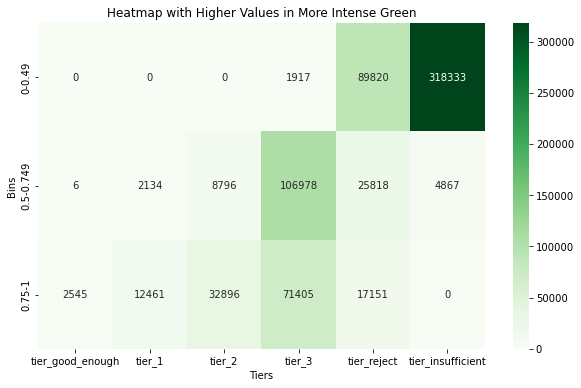

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
sns.heatmap(by_dqs[['tier_good_enough','tier_1', 'tier_2', 'tier_3', 'tier_reject', 'tier_insufficient']], cmap='Greens', annot=True, fmt='g')  # Use 'Greens' colormap for green shades
plt.title('Heatmap with Higher Values in More Intense Green')
plt.xlabel('Tiers')
plt.ylabel('Bins')
plt.show()

In [23]:
t1 = create_queries(t[t['tier_1'] == 'Tier 1'])
t2 = create_queries(t[t['tier_2'] == 'Tier 2'])
t3 = create_queries(t[t['tier_3'] == 'Tier 3'])
good_enough = create_queries(t[t['tier_good_enough'] == 'Good enough'])
rejected = create_queries(t[t['tier_reject'] == 'Reject'])
insufficient = create_queries(t[t['tier_insufficient'] == 'Insufficient'])

### Trenche breakdown

As expected, none of the tiers are invalid except for insufficient and rejected PEPs.

In [24]:
#pd.merge(t1, t2, on='count', how='inner')
t1['t2'] = t2['count']
t1['t3'] = t3['count']
t1['good enough'] = good_enough['count']
t1['rejected'] = rejected['count']
t1['insufficient'] = insufficient['count']
t1 = t1[['index', 'count', 't2', 't3', 'good enough', 'insufficient', 'rejected']].rename(columns={'index': 'invalid', 'count': 't1'})
t1

,invalid,t1,t2,t3,good enough,insufficient,rejected
Tranche,,,,,,,
4.0,"quality, age, name, occupation",0,0,0,0,994,994
3.0,"quality,age, occupation",0,0,0,0,67423,67465
,"quality,age, name",0,0,0,0,1334,1334
,"quality, name, occupation",0,0,0,0,78,97
,"age, name, occupation",0,0,0,0,0,0
2.0,"quality, age",0,0,0,0,210559,13584
,"quality, occupation",0,0,0,0,1524,3283
,"age, name",0,0,0,0,179,179
,"quality, name",0,0,0,0,75,88


### PEP tiers by source

Below is a breakdown of PEP tiers by their respective source. 

In [25]:
# By source
#t.filter(like='source').columns
by_source = t.groupby('_source.sources.source_ids')[['tier_good_enough','tier_1', 'tier_2', 'tier_3', 'tier_reject', 'tier_insufficient']].count()
by_source

,tier_good_enough,tier_1,tier_2,tier_3,tier_reject,tier_insufficient
_source.sources.source_ids,,,,,,
S:1GYJGG [The Official Board],0,0,0,0,54,20923
S:4CU7GM [PEP Everypolitician],2551,10802,27695,44434,47845,27242
S:8L276A [Manual PEPs],0,3793,13997,14021,78764,235127
S:FBFYW0 [DBPedia],0,0,0,121845,6028,35385
S:MFCNUA [PEP US Diplomat list 2],0,0,0,0,98,4523
